In [1]:
counter_id = 38230
site = 'wildberries.ru'

directory = 'client_data_%s' % site.split('.')[0]
print directory

client_data_wildberries


In [5]:
import pandas as pd
import numpy as np
import StringIO
import datetime
import plotly
import urllib
import json
from collections import defaultdict
import os


from sklearn import model_selection, preprocessing, linear_model, metrics, feature_extraction

In [6]:
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import graph_objs as go
import requests
import StringIO
import pandas as pd
import plotly

print __version__ # need 1.9.0 or greater

init_notebook_mode(connected = True)

def plotly_df(df, filename, title = ''):
    data = []
    
    for column in df.columns:
        trace = go.Scatter(
            x = df.index,
            y = df[column],
            mode = 'lines',
            name = column
        )
        data.append(trace)
    
    layout = dict(title = title)
    fig = dict(data = data, layout = layout)
    
    plotly.offline.plot(fig, filename=filename, show_link = False)
    
    iplot(fig, show_link = False)

3.3.0


In [10]:
HOST = 'http://mtch01m.metrika.yandex.net:8123'

import requests
def get_clickhouse_data(query, host = HOST, connection_timeout = 1500):
    r = requests.post(host, params = {'query': query, 'timeout_before_checking_execution_speed': 120}, auth=('miptgirl', '1QwBgINk'), 
                      timeout = connection_timeout)
    if r.status_code == 200:
        return r.text
    else:
        raise ValueError, r.text
        
def get_clickhouse_df(query, host = HOST, connection_timeout = 1500):
    data = get_clickhouse_data(query, host, connection_timeout) 
    df = pd.read_csv(StringIO.StringIO(data), sep = '\t')
    return df

def upload(table, content, connection_timeout = 2000, host = HOST):
    query_dict = {
             'query': 'INSERT INTO ' + table + ' FORMAT TabSeparated'
        }
    query_get = urllib.urlencode(query_dict)
    url = host + '?' + query_get
    print url
    r = requests.post(url, data=content, timeout=connection_timeout)
    result = r.text
    if 'Exception' in result:
        print host + ' \n ' + result
    else:
        return result
    
def daterange(start_date, end_date, step=1):
    for n in reversed(range(0, int((end_date - start_date).days + 1), step)):
        yield start_date + datetime.timedelta(n)

### Test model

In [143]:
COUNTERS = [27714477, 5503465]
N = 10

In [144]:
target_end_date = datetime.datetime(2019, 6, 13)
test_date = target_end_date - datetime.timedelta(7)

target_end_date, test_date

(datetime.datetime(2019, 6, 13, 0, 0), datetime.datetime(2019, 6, 6, 0, 0))

In [145]:
q = 'DROP TABLE IF EXISTS miptgirl.dda_train_users'
get_clickhouse_data(q)

q = '''
CREATE TABLE miptgirl.dda_train_users ENGINE = Log AS
    SELECT DISTINCT VisitID, UserID, CounterID, toUInt64(StartTime) as VisitTimestamp
    FROM visits_all SAMPLE 1/{N}
    WHERE StartDate = '{date}'
        and CounterID in ({counters})
'''.format(
    date = test_date.strftime('%Y-%m-%d'),
    counters = ', '.join(map(str, COUNTERS)),
    N = N
)
get_clickhouse_data(q)

u''

In [146]:
q = '''
SELECT
    CounterID as counter, 
    count() as users
FROM miptgirl.dda_train_users
GROUP BY counter
WITH TOTALS
FORMAT TSVWithNames
'''

get_clickhouse_df(q)

,counter,users
0,27714477,643269
1,5503465,73491
2,0,716760


In [147]:
q = '''
SELECT *
FROM miptgirl.dda_train_users
FORMAT TSVWithNames
'''

raw_df = get_clickhouse_df(q)

In [148]:
raw_df.head()

,VisitID,UserID,CounterID,VisitTimestamp
0,3107557329339616711,2468517011552541830,5503465,1559796790
1,3112819809150766691,6138645521515776676,5503465,1559816865
2,3112836382526213902,6138645521515776676,5503465,1559816928
3,3112847053366169168,6138645521515776676,5503465,1559816969
4,3119320677715480384,7222689611382791875,5503465,1559841664


In [149]:
q = '''
SELECT
    VisitID,
    count() as TargetVisits
FROM
    (SELECT
        VisitID,
        UserID,
        CounterID,
        VisitTimestamp,
        NextVisitTimestamp
    FROM
        (SELECT
            VisitID,
            UserID,
            CounterID,
            VisitTimestamp
        FROM  miptgirl.dda_train_users)
        ALL INNER JOIN
        (SELECT DISTINCT
            UserID, 
            CounterID,
            toUInt64(StartTime) as NextVisitTimestamp
        FROM visits_all SAMPLE 1/{N}
        WHERE StartDate >= '{date}'
            and StartDate <= '{end_date}'
            and CounterID in ({counters})
            and (UserID GLOBAL IN (SELECT DISTINCT UserID FROM miptgirl.dda_train_users)))
        USING (UserID, CounterID)
    WHERE (NextVisitTimestamp > VisitTimestamp)
        and ((NextVisitTimestamp - VisitTimestamp) <= 7*24*3600))
GROUP BY VisitID
FORMAT TSVWithNames
'''.format(
    date = test_date.strftime('%Y-%m-%d'),
    end_date = target_end_date.strftime('%Y-%m-%d'),
    counters = ', '.join(map(str, COUNTERS)),
    N = N
)

target_df = get_clickhouse_df(q)

In [150]:
target_df.head()

,VisitID,TargetVisits
0,3112324011186916787,4
1,3105145381252959914,12
2,3116851476112543102,9
3,3112939382637530923,2
4,3105795415572418057,14


In [151]:
%matplotlib inline
import seaborn

%config InlineBackend.figure_format = 'svg'
from pylab import rcParams
rcParams['figure.figsize'] = 8, 5

In [152]:
target_df = raw_df.merge(target_df, how = 'left').fillna(0)
target_df.TargetVisits = map(int, target_df.TargetVisits)

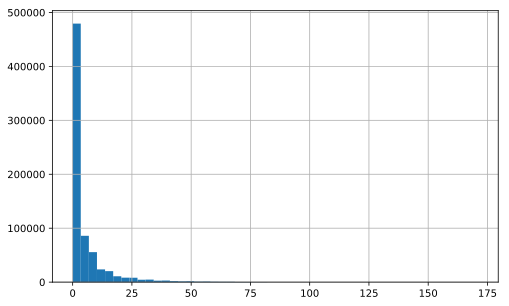

In [157]:
target_df.TargetVisits.hist(bins = 50)

In [158]:
target_df['Target'] = map(
    lambda x: 1 if x > 0 else 0,
    target_df.TargetVisits
)

In [159]:
target_df.Target.sum(), target_df.shape[0]

(468354, 716760)

In [160]:
target_df.head()

,VisitID,UserID,CounterID,VisitTimestamp,TargetVisits,Target
0,3107557329339616711,2468517011552541830,5503465,1559796790,1,1
1,3112819809150766691,6138645521515776676,5503465,1559816865,17,1
2,3112836382526213902,6138645521515776676,5503465,1559816928,16,1
3,3112847053366169168,6138645521515776676,5503465,1559816969,15,1
4,3119320677715480384,7222689611382791875,5503465,1559841664,9,1


In [161]:
q = '''
SELECT 
    VisitID,
    toHour(StartTime) as Hour,
    PageViews,
    Duration,
    IsBounce,
    GoalReachesAny,
    IsMobile,
    Age, 
    Sex,
    Income,
    StartDate - toDate(FirstVisit) as DaysSinceFirstVisit,
    StartDate - LastVisit as DaysSinceLastVisit,
    StartDate - PredLastVisit as DaysSincePredLastVisit,
    TotalVisits,
    TraficSource.ID[1] as FirstTraficSourceID,
    TraficSourceID as LastTraficSourceID,
    LastSignificantTraficSourceID,
    arraySum(Event.Activity) as EventActivity,
    arraySum(Event.Duration) as EventDuration,
    IsRobot,
    length(EPurchase.ID) as Purchases
FROM visits_all FINAL 
WHERE StartDate = '{date}'
    and CounterID in ({counters})
    and UserID GLOBAL IN (SELECT DISTINCT UserID FROM miptgirl.dda_train_users)
    and VisitID GLOBAL IN (SELECT VisitID FROM miptgirl.dda_train_users)
FORMAT TSVWithNames
'''.format(
    date = test_date.strftime('%Y-%m-%d'),
    counters = ', '.join(map(str, COUNTERS)),
    N = N
)

features_df = get_clickhouse_df(q)

In [162]:
features_df.shape[0]

716838

In [163]:
from sklearn import model_selection, preprocessing, linear_model, metrics, feature_extraction

In [164]:
df = features_df.merge(target_df[['VisitID', 'Target', 'TargetVisits']])

In [165]:
df.shape

(716838, 23)

In [166]:
df.head()

,VisitID,Hour,PageViews,Duration,IsBounce,GoalReachesAny,IsMobile,Age,Sex,Income,...,TotalVisits,FirstTraficSourceID,LastTraficSourceID,LastSignificantTraficSourceID,EventActivity,EventDuration,IsRobot,Purchases,Target,TargetVisits
0,3120607235882815176,21,1,138,0,2,0,25,1,3,...,2,3,3,3,6782,156,0,0,0,0
1,3121599108173467286,22,2,53,0,3,0,25,2,3,...,17,3,3,3,0,0,0,0,1,3
2,3122187103145758477,23,2,24,0,2,0,25,2,3,...,18,3,3,3,0,0,0,0,1,2
3,3111920716486217176,12,1,15,0,3,0,17,2,1,...,15,3,-1,3,0,0,0,0,1,4
4,3121176795099630993,22,1,16,0,2,0,17,1,0,...,16,3,-1,3,0,0,0,0,1,3


### Regression

In [167]:
features = ['Hour', 'PageViews', 'Duration', 
            'IsBounce', 'GoalReachesAny', 
            'IsMobile', 
            'DaysSinceFirstVisit', 'DaysSinceLastVisit', 'DaysSincePredLastVisit', 
            'TotalVisits', 'EventActivity', 'EventDuration', 'IsRobot', 'Purchases',
            'Age', 'Sex', 'Income', 
            'FirstTraficSourceID', 'LastTraficSourceID', 
            'LastSignificantTraficSourceID']

cat_features = map(lambda y: y[0],
    filter(
        lambda x: x[1] in (
            ['Age', 'Sex', 'Income', 'FirstTraficSourceID', 'LastTraficSourceID', 'LastSignificantTraficSourceID']),
        list(enumerate(features))
    )
)

In [168]:
X = df[features]
y = df.TargetVisits

(X_train, X_test, y_train, y_test) = model_selection.train_test_split(X, y, 
                                                              test_size = 0.3, 
                                                              random_state = 42)

In [171]:
# ', '.join(map(lambda x: "'%s'" % x, X_train.columns))

In [172]:
from catboost import CatBoostRegressor

In [173]:
reg_model = CatBoostRegressor(
    iterations=1000,
    #logging_level='Silent',
    random_seed = 42
)

reg_model.fit(X_train, y_train, 
    cat_features,
    eval_set=(X_test, y_test))

0:	learn: 10.0148242	test: 9.9851290	best: 9.9851290 (0)	total: 303ms	remaining: 5m 3s
1:	learn: 9.8169916	test: 9.7873343	best: 9.7873343 (1)	total: 610ms	remaining: 5m 4s
2:	learn: 9.6271659	test: 9.5976186	best: 9.5976186 (2)	total: 897ms	remaining: 4m 57s
3:	learn: 9.4451499	test: 9.4154659	best: 9.4154659 (3)	total: 1.11s	remaining: 4m 37s
4:	learn: 9.2704523	test: 9.2416290	best: 9.2416290 (4)	total: 1.39s	remaining: 4m 36s
5:	learn: 9.1007853	test: 9.0713746	best: 9.0713746 (5)	total: 1.65s	remaining: 4m 33s
6:	learn: 8.9381681	test: 8.9095779	best: 8.9095779 (6)	total: 1.92s	remaining: 4m 32s
7:	learn: 8.7810191	test: 8.7528242	best: 8.7528242 (7)	total: 2.17s	remaining: 4m 28s
8:	learn: 8.6288199	test: 8.6007203	best: 8.6007203 (8)	total: 2.4s	remaining: 4m 24s
9:	learn: 8.4812089	test: 8.4539207	best: 8.4539207 (9)	total: 2.66s	remaining: 4m 23s
10:	learn: 8.3393350	test: 8.3122063	best: 8.3122063 (10)	total: 2.92s	remaining: 4m 22s
11:	learn: 8.2016825	test: 8.1754890	best: 

93:	learn: 4.7394439	test: 4.7466605	best: 4.7466605 (93)	total: 23s	remaining: 3m 41s
94:	learn: 4.7312323	test: 4.7387051	best: 4.7387051 (94)	total: 23.2s	remaining: 3m 41s
95:	learn: 4.7241196	test: 4.7318620	best: 4.7318620 (95)	total: 23.4s	remaining: 3m 40s
96:	learn: 4.7163048	test: 4.7244688	best: 4.7244688 (96)	total: 23.7s	remaining: 3m 40s
97:	learn: 4.7087044	test: 4.7171441	best: 4.7171441 (97)	total: 23.9s	remaining: 3m 39s
98:	learn: 4.7016554	test: 4.7104694	best: 4.7104694 (98)	total: 24.1s	remaining: 3m 39s
99:	learn: 4.6944513	test: 4.7034724	best: 4.7034724 (99)	total: 24.3s	remaining: 3m 38s
100:	learn: 4.6880576	test: 4.6970700	best: 4.6970700 (100)	total: 24.5s	remaining: 3m 38s
101:	learn: 4.6815671	test: 4.6910707	best: 4.6910707 (101)	total: 24.7s	remaining: 3m 37s
102:	learn: 4.6756420	test: 4.6856186	best: 4.6856186 (102)	total: 25s	remaining: 3m 37s
103:	learn: 4.6691435	test: 4.6796622	best: 4.6796622 (103)	total: 25.2s	remaining: 3m 37s
104:	learn: 4.663

184:	learn: 4.4170458	test: 4.4500154	best: 4.4500154 (184)	total: 43.8s	remaining: 3m 12s
185:	learn: 4.4154478	test: 4.4485653	best: 4.4485653 (185)	total: 44s	remaining: 3m 12s
186:	learn: 4.4141443	test: 4.4473836	best: 4.4473836 (186)	total: 44.3s	remaining: 3m 12s
187:	learn: 4.4127675	test: 4.4461368	best: 4.4461368 (187)	total: 44.5s	remaining: 3m 12s
188:	learn: 4.4117439	test: 4.4452502	best: 4.4452502 (188)	total: 44.7s	remaining: 3m 11s
189:	learn: 4.4106484	test: 4.4442621	best: 4.4442621 (189)	total: 45s	remaining: 3m 11s
190:	learn: 4.4096559	test: 4.4435250	best: 4.4435250 (190)	total: 45.1s	remaining: 3m 11s
191:	learn: 4.4074018	test: 4.4415724	best: 4.4415724 (191)	total: 45.4s	remaining: 3m 10s
192:	learn: 4.4060452	test: 4.4402511	best: 4.4402511 (192)	total: 45.6s	remaining: 3m 10s
193:	learn: 4.4042923	test: 4.4387841	best: 4.4387841 (193)	total: 45.9s	remaining: 3m 10s
194:	learn: 4.4027511	test: 4.4374368	best: 4.4374368 (194)	total: 46.1s	remaining: 3m 10s
195

275:	learn: 4.3203931	test: 4.3672442	best: 4.3672442 (275)	total: 1m 4s	remaining: 2m 50s
276:	learn: 4.3201296	test: 4.3670811	best: 4.3670811 (276)	total: 1m 5s	remaining: 2m 49s
277:	learn: 4.3195899	test: 4.3664086	best: 4.3664086 (277)	total: 1m 5s	remaining: 2m 49s
278:	learn: 4.3187262	test: 4.3655790	best: 4.3655790 (278)	total: 1m 5s	remaining: 2m 49s
279:	learn: 4.3179131	test: 4.3650931	best: 4.3650931 (279)	total: 1m 5s	remaining: 2m 49s
280:	learn: 4.3171669	test: 4.3644797	best: 4.3644797 (280)	total: 1m 5s	remaining: 2m 48s
281:	learn: 4.3167857	test: 4.3641693	best: 4.3641693 (281)	total: 1m 6s	remaining: 2m 48s
282:	learn: 4.3156060	test: 4.3629370	best: 4.3629370 (282)	total: 1m 6s	remaining: 2m 48s
283:	learn: 4.3152000	test: 4.3626756	best: 4.3626756 (283)	total: 1m 6s	remaining: 2m 48s
284:	learn: 4.3146723	test: 4.3623313	best: 4.3623313 (284)	total: 1m 6s	remaining: 2m 47s
285:	learn: 4.3139390	test: 4.3616932	best: 4.3616932 (285)	total: 1m 7s	remaining: 2m 47s

365:	learn: 4.2604766	test: 4.3147787	best: 4.3147787 (365)	total: 1m 25s	remaining: 2m 28s
366:	learn: 4.2600777	test: 4.3144580	best: 4.3144580 (366)	total: 1m 25s	remaining: 2m 28s
367:	learn: 4.2593484	test: 4.3137399	best: 4.3137399 (367)	total: 1m 26s	remaining: 2m 28s
368:	learn: 4.2588269	test: 4.3133082	best: 4.3133082 (368)	total: 1m 26s	remaining: 2m 27s
369:	learn: 4.2584512	test: 4.3130612	best: 4.3130612 (369)	total: 1m 26s	remaining: 2m 27s
370:	learn: 4.2583263	test: 4.3129610	best: 4.3129610 (370)	total: 1m 26s	remaining: 2m 27s
371:	learn: 4.2579452	test: 4.3127142	best: 4.3127142 (371)	total: 1m 27s	remaining: 2m 27s
372:	learn: 4.2576127	test: 4.3124966	best: 4.3124966 (372)	total: 1m 27s	remaining: 2m 26s
373:	learn: 4.2566493	test: 4.3120704	best: 4.3120704 (373)	total: 1m 27s	remaining: 2m 26s
374:	learn: 4.2559572	test: 4.3113461	best: 4.3113461 (374)	total: 1m 27s	remaining: 2m 26s
375:	learn: 4.2552651	test: 4.3108124	best: 4.3108124 (375)	total: 1m 28s	remain

455:	learn: 4.2194604	test: 4.2798695	best: 4.2798695 (455)	total: 1m 46s	remaining: 2m 6s
456:	learn: 4.2190364	test: 4.2795428	best: 4.2795428 (456)	total: 1m 46s	remaining: 2m 6s
457:	learn: 4.2187869	test: 4.2793756	best: 4.2793756 (457)	total: 1m 46s	remaining: 2m 6s
458:	learn: 4.2187139	test: 4.2793065	best: 4.2793065 (458)	total: 1m 46s	remaining: 2m 5s
459:	learn: 4.2181259	test: 4.2788925	best: 4.2788925 (459)	total: 1m 47s	remaining: 2m 5s
460:	learn: 4.2175694	test: 4.2782368	best: 4.2782368 (460)	total: 1m 47s	remaining: 2m 5s
461:	learn: 4.2175232	test: 4.2782130	best: 4.2782130 (461)	total: 1m 47s	remaining: 2m 5s
462:	learn: 4.2168598	test: 4.2775900	best: 4.2775900 (462)	total: 1m 47s	remaining: 2m 5s
463:	learn: 4.2167967	test: 4.2775527	best: 4.2775527 (463)	total: 1m 48s	remaining: 2m 4s
464:	learn: 4.2165667	test: 4.2774500	best: 4.2774500 (464)	total: 1m 48s	remaining: 2m 4s
465:	learn: 4.2161202	test: 4.2772865	best: 4.2772865 (465)	total: 1m 48s	remaining: 2m 4s

545:	learn: 4.1911288	test: 4.2559560	best: 4.2559560 (545)	total: 2m 7s	remaining: 1m 45s
546:	learn: 4.1910431	test: 4.2558754	best: 4.2558754 (546)	total: 2m 7s	remaining: 1m 45s
547:	learn: 4.1909953	test: 4.2558536	best: 4.2558536 (547)	total: 2m 7s	remaining: 1m 45s
548:	learn: 4.1909894	test: 4.2558508	best: 4.2558508 (548)	total: 2m 7s	remaining: 1m 44s
549:	learn: 4.1907198	test: 4.2555164	best: 4.2555164 (549)	total: 2m 7s	remaining: 1m 44s
550:	learn: 4.1904683	test: 4.2552812	best: 4.2552812 (550)	total: 2m 8s	remaining: 1m 44s
551:	learn: 4.1901903	test: 4.2549746	best: 4.2549746 (551)	total: 2m 8s	remaining: 1m 44s
552:	learn: 4.1899170	test: 4.2547987	best: 4.2547987 (552)	total: 2m 8s	remaining: 1m 43s
553:	learn: 4.1896916	test: 4.2546039	best: 4.2546039 (553)	total: 2m 8s	remaining: 1m 43s
554:	learn: 4.1894092	test: 4.2543542	best: 4.2543542 (554)	total: 2m 9s	remaining: 1m 43s
555:	learn: 4.1892367	test: 4.2542245	best: 4.2542245 (555)	total: 2m 9s	remaining: 1m 43s

635:	learn: 4.1713276	test: 4.2393985	best: 4.2393985 (635)	total: 2m 27s	remaining: 1m 24s
636:	learn: 4.1708917	test: 4.2389540	best: 4.2389540 (636)	total: 2m 28s	remaining: 1m 24s
637:	learn: 4.1706545	test: 4.2387933	best: 4.2387933 (637)	total: 2m 28s	remaining: 1m 24s
638:	learn: 4.1704371	test: 4.2385399	best: 4.2385399 (638)	total: 2m 28s	remaining: 1m 23s
639:	learn: 4.1702189	test: 4.2384122	best: 4.2384122 (639)	total: 2m 28s	remaining: 1m 23s
640:	learn: 4.1700289	test: 4.2383105	best: 4.2383105 (640)	total: 2m 29s	remaining: 1m 23s
641:	learn: 4.1697381	test: 4.2380716	best: 4.2380716 (641)	total: 2m 29s	remaining: 1m 23s
642:	learn: 4.1695302	test: 4.2378938	best: 4.2378938 (642)	total: 2m 29s	remaining: 1m 23s
643:	learn: 4.1694329	test: 4.2378419	best: 4.2378419 (643)	total: 2m 29s	remaining: 1m 22s
644:	learn: 4.1689682	test: 4.2373979	best: 4.2373979 (644)	total: 2m 30s	remaining: 1m 22s
645:	learn: 4.1688891	test: 4.2374030	best: 4.2373979 (644)	total: 2m 30s	remain

725:	learn: 4.1536678	test: 4.2251112	best: 4.2251112 (725)	total: 2m 48s	remaining: 1m 3s
726:	learn: 4.1535804	test: 4.2250934	best: 4.2250934 (726)	total: 2m 49s	remaining: 1m 3s
727:	learn: 4.1531496	test: 4.2248929	best: 4.2248929 (727)	total: 2m 49s	remaining: 1m 3s
728:	learn: 4.1526272	test: 4.2246648	best: 4.2246648 (728)	total: 2m 49s	remaining: 1m 3s
729:	learn: 4.1525368	test: 4.2246338	best: 4.2246338 (729)	total: 2m 49s	remaining: 1m 2s
730:	learn: 4.1523861	test: 4.2244992	best: 4.2244992 (730)	total: 2m 50s	remaining: 1m 2s
731:	learn: 4.1522263	test: 4.2243748	best: 4.2243748 (731)	total: 2m 50s	remaining: 1m 2s
732:	learn: 4.1520044	test: 4.2241400	best: 4.2241400 (732)	total: 2m 50s	remaining: 1m 2s
733:	learn: 4.1518441	test: 4.2240217	best: 4.2240217 (733)	total: 2m 50s	remaining: 1m 1s
734:	learn: 4.1516954	test: 4.2239284	best: 4.2239284 (734)	total: 2m 51s	remaining: 1m 1s
735:	learn: 4.1515597	test: 4.2238820	best: 4.2238820 (735)	total: 2m 51s	remaining: 1m 1s

816:	learn: 4.1381212	test: 4.2145901	best: 4.2145901 (816)	total: 3m 9s	remaining: 42.5s
817:	learn: 4.1379468	test: 4.2143018	best: 4.2143018 (817)	total: 3m 10s	remaining: 42.3s
818:	learn: 4.1378719	test: 4.2142725	best: 4.2142725 (818)	total: 3m 10s	remaining: 42s
819:	learn: 4.1377929	test: 4.2142158	best: 4.2142158 (819)	total: 3m 10s	remaining: 41.8s
820:	learn: 4.1376932	test: 4.2141352	best: 4.2141352 (820)	total: 3m 10s	remaining: 41.6s
821:	learn: 4.1376339	test: 4.2141092	best: 4.2141092 (821)	total: 3m 10s	remaining: 41.3s
822:	learn: 4.1376265	test: 4.2141096	best: 4.2141092 (821)	total: 3m 11s	remaining: 41.1s
823:	learn: 4.1376090	test: 4.2141022	best: 4.2141022 (823)	total: 3m 11s	remaining: 40.9s
824:	learn: 4.1373493	test: 4.2139183	best: 4.2139183 (824)	total: 3m 11s	remaining: 40.6s
825:	learn: 4.1372055	test: 4.2137723	best: 4.2137723 (825)	total: 3m 11s	remaining: 40.4s
826:	learn: 4.1371370	test: 4.2137739	best: 4.2137723 (825)	total: 3m 12s	remaining: 40.2s
82

907:	learn: 4.1240587	test: 4.2039416	best: 4.2039416 (907)	total: 3m 30s	remaining: 21.4s
908:	learn: 4.1239650	test: 4.2038348	best: 4.2038348 (908)	total: 3m 31s	remaining: 21.1s
909:	learn: 4.1237464	test: 4.2037081	best: 4.2037081 (909)	total: 3m 31s	remaining: 20.9s
910:	learn: 4.1237047	test: 4.2036827	best: 4.2036827 (910)	total: 3m 31s	remaining: 20.7s
911:	learn: 4.1236180	test: 4.2036745	best: 4.2036745 (911)	total: 3m 31s	remaining: 20.4s
912:	learn: 4.1234936	test: 4.2036608	best: 4.2036608 (912)	total: 3m 32s	remaining: 20.2s
913:	learn: 4.1233666	test: 4.2035715	best: 4.2035715 (913)	total: 3m 32s	remaining: 20s
914:	learn: 4.1231946	test: 4.2034133	best: 4.2034133 (914)	total: 3m 32s	remaining: 19.7s
915:	learn: 4.1227257	test: 4.2029730	best: 4.2029730 (915)	total: 3m 32s	remaining: 19.5s
916:	learn: 4.1226155	test: 4.2028662	best: 4.2028662 (916)	total: 3m 33s	remaining: 19.3s
917:	learn: 4.1225681	test: 4.2028752	best: 4.2028662 (916)	total: 3m 33s	remaining: 19s
918

998:	learn: 4.1121150	test: 4.1957947	best: 4.1957947 (998)	total: 3m 52s	remaining: 233ms
999:	learn: 4.1120721	test: 4.1957771	best: 4.1957771 (999)	total: 3m 52s	remaining: 0us

bestTest = 4.195777124
bestIteration = 999

Shrink model to first 1000 iterations.


In [174]:
reg_model.score(X_test, y_test)

4.195777124243948

In [175]:
reg_model.tree_count_

1000

In [179]:
reg_model.save_model('reg_catboost_model.bin', format = 'cbm')

### Classification

In [177]:
X = df[features]
y = df.Target

(X_train, X_test, y_train, y_test) = model_selection.train_test_split(X, y, 
                                                              test_size = 0.3, 
                                                              random_state = 42)

In [178]:
from catboost import CatBoostClassifier

In [190]:
class_model = CatBoostClassifier(
    iterations=1000,
    #logging_level='Silent',
    custom_metric = ['AUC', 'Precision', 'Recall', 'Accuracy'],
    random_seed = 42
)

class_model.fit(X_train, y_train, 
    cat_features,
    eval_set=(X_test, y_test))

Learning rate set to 0.149901
0:	learn: 0.6027583	test: 0.6027981	best: 0.6027981 (0)	total: 349ms	remaining: 5m 48s
1:	learn: 0.5461151	test: 0.5460009	best: 0.5460009 (1)	total: 701ms	remaining: 5m 49s
2:	learn: 0.5073760	test: 0.5070850	best: 0.5070850 (2)	total: 1.02s	remaining: 5m 40s
3:	learn: 0.4833872	test: 0.4829393	best: 0.4829393 (3)	total: 1.39s	remaining: 5m 46s
4:	learn: 0.4662905	test: 0.4657313	best: 0.4657313 (4)	total: 1.75s	remaining: 5m 48s
5:	learn: 0.4533951	test: 0.4526785	best: 0.4526785 (5)	total: 2.09s	remaining: 5m 47s
6:	learn: 0.4430868	test: 0.4423241	best: 0.4423241 (6)	total: 2.43s	remaining: 5m 44s
7:	learn: 0.4352661	test: 0.4343952	best: 0.4343952 (7)	total: 2.8s	remaining: 5m 46s
8:	learn: 0.4307794	test: 0.4298483	best: 0.4298483 (8)	total: 3.11s	remaining: 5m 42s
9:	learn: 0.4281816	test: 0.4271981	best: 0.4271981 (9)	total: 3.43s	remaining: 5m 39s
10:	learn: 0.4244493	test: 0.4234633	best: 0.4234633 (10)	total: 3.76s	remaining: 5m 38s
11:	learn: 0

93:	learn: 0.4042988	test: 0.4045991	best: 0.4045991 (93)	total: 30.9s	remaining: 4m 57s
94:	learn: 0.4042671	test: 0.4045769	best: 0.4045769 (94)	total: 31.2s	remaining: 4m 57s
95:	learn: 0.4042546	test: 0.4045646	best: 0.4045646 (95)	total: 31.5s	remaining: 4m 57s
96:	learn: 0.4042285	test: 0.4045505	best: 0.4045505 (96)	total: 31.8s	remaining: 4m 56s
97:	learn: 0.4042129	test: 0.4045504	best: 0.4045504 (97)	total: 32.2s	remaining: 4m 56s
98:	learn: 0.4041782	test: 0.4045323	best: 0.4045323 (98)	total: 32.5s	remaining: 4m 56s
99:	learn: 0.4041507	test: 0.4045183	best: 0.4045183 (99)	total: 32.8s	remaining: 4m 55s
100:	learn: 0.4041226	test: 0.4044961	best: 0.4044961 (100)	total: 33.1s	remaining: 4m 54s
101:	learn: 0.4041016	test: 0.4044930	best: 0.4044930 (101)	total: 33.5s	remaining: 4m 54s
102:	learn: 0.4040500	test: 0.4044566	best: 0.4044566 (102)	total: 33.8s	remaining: 4m 54s
103:	learn: 0.4040161	test: 0.4044362	best: 0.4044362 (103)	total: 34.1s	remaining: 4m 53s
104:	learn: 0

184:	learn: 0.4024090	test: 0.4038377	best: 0.4038377 (184)	total: 1m	remaining: 4m 24s
185:	learn: 0.4023989	test: 0.4038357	best: 0.4038357 (185)	total: 1m	remaining: 4m 24s
186:	learn: 0.4023750	test: 0.4038255	best: 0.4038255 (186)	total: 1m	remaining: 4m 24s
187:	learn: 0.4023449	test: 0.4038119	best: 0.4038119 (187)	total: 1m 1s	remaining: 4m 23s
188:	learn: 0.4023392	test: 0.4038103	best: 0.4038103 (188)	total: 1m 1s	remaining: 4m 23s
189:	learn: 0.4023150	test: 0.4037988	best: 0.4037988 (189)	total: 1m 1s	remaining: 4m 23s
190:	learn: 0.4023059	test: 0.4037951	best: 0.4037951 (190)	total: 1m 2s	remaining: 4m 22s
191:	learn: 0.4022846	test: 0.4037882	best: 0.4037882 (191)	total: 1m 2s	remaining: 4m 22s
192:	learn: 0.4022634	test: 0.4037856	best: 0.4037856 (192)	total: 1m 2s	remaining: 4m 22s
193:	learn: 0.4022445	test: 0.4037873	best: 0.4037856 (192)	total: 1m 3s	remaining: 4m 21s
194:	learn: 0.4022231	test: 0.4037875	best: 0.4037856 (192)	total: 1m 3s	remaining: 4m 21s
195:	lea

274:	learn: 0.4010601	test: 0.4036216	best: 0.4036173 (272)	total: 1m 29s	remaining: 3m 56s
275:	learn: 0.4010320	test: 0.4036183	best: 0.4036173 (272)	total: 1m 30s	remaining: 3m 56s
276:	learn: 0.4010050	test: 0.4036240	best: 0.4036173 (272)	total: 1m 30s	remaining: 3m 56s
277:	learn: 0.4009953	test: 0.4036178	best: 0.4036173 (272)	total: 1m 30s	remaining: 3m 55s
278:	learn: 0.4009890	test: 0.4036083	best: 0.4036083 (278)	total: 1m 31s	remaining: 3m 55s
279:	learn: 0.4009695	test: 0.4036011	best: 0.4036011 (279)	total: 1m 31s	remaining: 3m 55s
280:	learn: 0.4009561	test: 0.4035976	best: 0.4035976 (280)	total: 1m 31s	remaining: 3m 54s
281:	learn: 0.4009491	test: 0.4035980	best: 0.4035976 (280)	total: 1m 32s	remaining: 3m 54s
282:	learn: 0.4009384	test: 0.4035966	best: 0.4035966 (282)	total: 1m 32s	remaining: 3m 54s
283:	learn: 0.4009187	test: 0.4035883	best: 0.4035883 (283)	total: 1m 32s	remaining: 3m 53s
284:	learn: 0.4009081	test: 0.4035894	best: 0.4035883 (283)	total: 1m 33s	remain

364:	learn: 0.3998772	test: 0.4035374	best: 0.4035326 (345)	total: 1m 58s	remaining: 3m 26s
365:	learn: 0.3998619	test: 0.4035364	best: 0.4035326 (345)	total: 1m 59s	remaining: 3m 26s
366:	learn: 0.3998433	test: 0.4035298	best: 0.4035298 (366)	total: 1m 59s	remaining: 3m 26s
367:	learn: 0.3998402	test: 0.4035299	best: 0.4035298 (366)	total: 1m 59s	remaining: 3m 25s
368:	learn: 0.3998283	test: 0.4035250	best: 0.4035250 (368)	total: 2m	remaining: 3m 25s
369:	learn: 0.3998209	test: 0.4035309	best: 0.4035250 (368)	total: 2m	remaining: 3m 25s
370:	learn: 0.3998078	test: 0.4035241	best: 0.4035241 (370)	total: 2m	remaining: 3m 24s
371:	learn: 0.3997963	test: 0.4035181	best: 0.4035181 (371)	total: 2m 1s	remaining: 3m 24s
372:	learn: 0.3997860	test: 0.4035151	best: 0.4035151 (372)	total: 2m 1s	remaining: 3m 24s
373:	learn: 0.3997736	test: 0.4035157	best: 0.4035151 (372)	total: 2m 1s	remaining: 3m 24s
374:	learn: 0.3997675	test: 0.4035156	best: 0.4035151 (372)	total: 2m 2s	remaining: 3m 23s
375:

454:	learn: 0.3988681	test: 0.4035045	best: 0.4034819 (439)	total: 2m 29s	remaining: 2m 58s
455:	learn: 0.3988540	test: 0.4035045	best: 0.4034819 (439)	total: 2m 29s	remaining: 2m 58s
456:	learn: 0.3988495	test: 0.4035068	best: 0.4034819 (439)	total: 2m 29s	remaining: 2m 57s
457:	learn: 0.3988411	test: 0.4035021	best: 0.4034819 (439)	total: 2m 30s	remaining: 2m 57s
458:	learn: 0.3988361	test: 0.4035022	best: 0.4034819 (439)	total: 2m 30s	remaining: 2m 57s
459:	learn: 0.3988277	test: 0.4034979	best: 0.4034819 (439)	total: 2m 30s	remaining: 2m 56s
460:	learn: 0.3988201	test: 0.4034951	best: 0.4034819 (439)	total: 2m 31s	remaining: 2m 56s
461:	learn: 0.3988128	test: 0.4034972	best: 0.4034819 (439)	total: 2m 31s	remaining: 2m 56s
462:	learn: 0.3987997	test: 0.4034972	best: 0.4034819 (439)	total: 2m 31s	remaining: 2m 55s
463:	learn: 0.3987857	test: 0.4035038	best: 0.4034819 (439)	total: 2m 31s	remaining: 2m 55s
464:	learn: 0.3987777	test: 0.4035040	best: 0.4034819 (439)	total: 2m 32s	remain

544:	learn: 0.3980222	test: 0.4034702	best: 0.4034677 (540)	total: 2m 58s	remaining: 2m 29s
545:	learn: 0.3980131	test: 0.4034700	best: 0.4034677 (540)	total: 2m 58s	remaining: 2m 28s
546:	learn: 0.3980075	test: 0.4034718	best: 0.4034677 (540)	total: 2m 59s	remaining: 2m 28s
547:	learn: 0.3979933	test: 0.4034791	best: 0.4034677 (540)	total: 2m 59s	remaining: 2m 28s
548:	learn: 0.3979763	test: 0.4034835	best: 0.4034677 (540)	total: 2m 59s	remaining: 2m 27s
549:	learn: 0.3979642	test: 0.4034833	best: 0.4034677 (540)	total: 3m	remaining: 2m 27s
550:	learn: 0.3979515	test: 0.4034867	best: 0.4034677 (540)	total: 3m	remaining: 2m 27s
551:	learn: 0.3979473	test: 0.4034834	best: 0.4034677 (540)	total: 3m	remaining: 2m 26s
552:	learn: 0.3979394	test: 0.4034839	best: 0.4034677 (540)	total: 3m 1s	remaining: 2m 26s
553:	learn: 0.3979313	test: 0.4034824	best: 0.4034677 (540)	total: 3m 1s	remaining: 2m 26s
554:	learn: 0.3979281	test: 0.4034826	best: 0.4034677 (540)	total: 3m 1s	remaining: 2m 25s
555

634:	learn: 0.3971545	test: 0.4035041	best: 0.4034503 (581)	total: 3m 28s	remaining: 2m
635:	learn: 0.3971492	test: 0.4035072	best: 0.4034503 (581)	total: 3m 29s	remaining: 1m 59s
636:	learn: 0.3971399	test: 0.4035098	best: 0.4034503 (581)	total: 3m 29s	remaining: 1m 59s
637:	learn: 0.3971375	test: 0.4035099	best: 0.4034503 (581)	total: 3m 29s	remaining: 1m 59s
638:	learn: 0.3971280	test: 0.4035049	best: 0.4034503 (581)	total: 3m 30s	remaining: 1m 58s
639:	learn: 0.3971150	test: 0.4035076	best: 0.4034503 (581)	total: 3m 30s	remaining: 1m 58s
640:	learn: 0.3971085	test: 0.4035067	best: 0.4034503 (581)	total: 3m 30s	remaining: 1m 58s
641:	learn: 0.3970928	test: 0.4035069	best: 0.4034503 (581)	total: 3m 31s	remaining: 1m 57s
642:	learn: 0.3970760	test: 0.4035077	best: 0.4034503 (581)	total: 3m 31s	remaining: 1m 57s
643:	learn: 0.3970722	test: 0.4035128	best: 0.4034503 (581)	total: 3m 31s	remaining: 1m 57s
644:	learn: 0.3970702	test: 0.4035118	best: 0.4034503 (581)	total: 3m 32s	remaining:

724:	learn: 0.3962487	test: 0.4035709	best: 0.4034503 (581)	total: 3m 58s	remaining: 1m 30s
725:	learn: 0.3962398	test: 0.4035721	best: 0.4034503 (581)	total: 3m 59s	remaining: 1m 30s
726:	learn: 0.3962282	test: 0.4035722	best: 0.4034503 (581)	total: 3m 59s	remaining: 1m 29s
727:	learn: 0.3962235	test: 0.4035781	best: 0.4034503 (581)	total: 3m 59s	remaining: 1m 29s
728:	learn: 0.3962152	test: 0.4035830	best: 0.4034503 (581)	total: 4m	remaining: 1m 29s
729:	learn: 0.3961992	test: 0.4035792	best: 0.4034503 (581)	total: 4m	remaining: 1m 28s
730:	learn: 0.3961913	test: 0.4035795	best: 0.4034503 (581)	total: 4m	remaining: 1m 28s
731:	learn: 0.3961858	test: 0.4035773	best: 0.4034503 (581)	total: 4m 1s	remaining: 1m 28s
732:	learn: 0.3961717	test: 0.4035745	best: 0.4034503 (581)	total: 4m 1s	remaining: 1m 27s
733:	learn: 0.3961688	test: 0.4035728	best: 0.4034503 (581)	total: 4m 1s	remaining: 1m 27s
734:	learn: 0.3961655	test: 0.4035721	best: 0.4034503 (581)	total: 4m 2s	remaining: 1m 27s
735:

814:	learn: 0.3954184	test: 0.4036216	best: 0.4034503 (581)	total: 4m 29s	remaining: 1m 1s
815:	learn: 0.3954100	test: 0.4036220	best: 0.4034503 (581)	total: 4m 29s	remaining: 1m
816:	learn: 0.3953992	test: 0.4036240	best: 0.4034503 (581)	total: 4m 29s	remaining: 1m
817:	learn: 0.3953872	test: 0.4036228	best: 0.4034503 (581)	total: 4m 30s	remaining: 1m
818:	learn: 0.3953843	test: 0.4036227	best: 0.4034503 (581)	total: 4m 30s	remaining: 59.8s
819:	learn: 0.3953733	test: 0.4036228	best: 0.4034503 (581)	total: 4m 30s	remaining: 59.4s
820:	learn: 0.3953612	test: 0.4036223	best: 0.4034503 (581)	total: 4m 31s	remaining: 59.1s
821:	learn: 0.3953419	test: 0.4036232	best: 0.4034503 (581)	total: 4m 31s	remaining: 58.8s
822:	learn: 0.3953299	test: 0.4036230	best: 0.4034503 (581)	total: 4m 31s	remaining: 58.5s
823:	learn: 0.3953170	test: 0.4036160	best: 0.4034503 (581)	total: 4m 32s	remaining: 58.1s
824:	learn: 0.3952984	test: 0.4036160	best: 0.4034503 (581)	total: 4m 32s	remaining: 57.8s
825:	lea

905:	learn: 0.3944899	test: 0.4036819	best: 0.4034503 (581)	total: 4m 59s	remaining: 31.1s
906:	learn: 0.3944858	test: 0.4036823	best: 0.4034503 (581)	total: 5m	remaining: 30.8s
907:	learn: 0.3944750	test: 0.4036826	best: 0.4034503 (581)	total: 5m	remaining: 30.5s
908:	learn: 0.3944624	test: 0.4036794	best: 0.4034503 (581)	total: 5m	remaining: 30.1s
909:	learn: 0.3944554	test: 0.4036801	best: 0.4034503 (581)	total: 5m 1s	remaining: 29.8s
910:	learn: 0.3944478	test: 0.4036754	best: 0.4034503 (581)	total: 5m 1s	remaining: 29.5s
911:	learn: 0.3944417	test: 0.4036802	best: 0.4034503 (581)	total: 5m 1s	remaining: 29.1s
912:	learn: 0.3944331	test: 0.4036770	best: 0.4034503 (581)	total: 5m 2s	remaining: 28.8s
913:	learn: 0.3944281	test: 0.4036787	best: 0.4034503 (581)	total: 5m 2s	remaining: 28.5s
914:	learn: 0.3944239	test: 0.4036815	best: 0.4034503 (581)	total: 5m 2s	remaining: 28.1s
915:	learn: 0.3944224	test: 0.4036820	best: 0.4034503 (581)	total: 5m 3s	remaining: 27.8s
916:	learn: 0.3944

996:	learn: 0.3936923	test: 0.4037228	best: 0.4034503 (581)	total: 5m 30s	remaining: 994ms
997:	learn: 0.3936832	test: 0.4037219	best: 0.4034503 (581)	total: 5m 30s	remaining: 663ms
998:	learn: 0.3936750	test: 0.4037236	best: 0.4034503 (581)	total: 5m 30s	remaining: 331ms
999:	learn: 0.3936689	test: 0.4037260	best: 0.4034503 (581)	total: 5m 31s	remaining: 0us

bestTest = 0.4034503121
bestIteration = 581

Shrink model to first 582 iterations.


In [193]:
class_model.score(X_test, y_test)

0.8089950337592768

In [194]:
class_model.score(X_train, y_train)

0.8125396085183724

In [192]:
class_model.save_model('class_catboost_model.bin', format = 'cbm')